In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from skimage.io import imread
import os
from glob import glob
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from keras import backend as K
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
from keras.layers import BatchNormalization

%matplotlib inline 

Using TensorFlow backend.


## basic parameters

In [3]:
batch_size = 128
img_size = 299

# define project location
proj_dir = '../Data/Diabetes/'
train_path = os.path.join(proj_dir,'train')
test_path = os.path.join(proj_dir,'test')

## read image

In [4]:
# read training labels
train_label_df = pd.read_csv(os.path.join(proj_dir, 'trainLabels.csv'))
train_label_df['PatientId'] = train_label_df['image'].map(lambda x: x.split('_')[0])
train_label_df['path'] = train_label_df['image'].map(lambda x: os.path.join(proj_dir,'train' ,'{}.jpeg'.format(x)))
train_label_df['exists'] = train_label_df['path'].map(os.path.exists)
# add label for left eye
train_label_df['l_eye'] = train_label_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)
# one hot coding for label
train_label_df['level_cat'] = train_label_df['level'].map(lambda x: to_categorical(x, 1+train_label_df['level'].max()))
train_label_df.dropna(inplace = True)
train_label_df = train_label_df[train_label_df['exists']]

## Divide data to training and validation

In [ ]:
train_label_uniq_df = train_label_df[['PatientId', 'level']].drop_duplicates()
train_ids, valid_ids = train_test_split(train_label_uniq_df ['PatientId'], 
                                   test_size = 0.2, 
                                   random_state = 19,
                                   stratify = train_label_uniq_df ['level'])
train_df_temp = train_label_df[train_label_df['PatientId'].isin(train_ids)]
valid_df = train_label_df[train_label_df['PatientId'].isin(valid_ids)]
print(train_df_temp.groupby('level').count())
print('train', train_df_temp.shape[0], 'validation', valid_df.shape[0])

train_df = train_df_temp.groupby(['level', 'l_eye']).apply(lambda x: x.sample(1200, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', train_df_temp.shape[0])
train_df[['level', 'l_eye']].hist(figsize = (10, 5))

In [6]:
# image augment
# these augment functions are collected from Kaggle

def tf_image_loader(out_size, 
                    horizontal_flip = True, 
                    vertical_flip = False, 
                    random_brightness = True,
                    random_contrast = True,
                    random_saturation = True,
                    random_hue = True,
                    color_mode = 'rgb',
                    preproc_func = preprocess_input,
                    on_batch = False):
    def _func(X):
        with tf.name_scope('image_augmentation'):
            with tf.name_scope('input'):
                X = tf.image.decode_png(tf.read_file(X), channels = 3 if color_mode == 'rgb' else 0)
                X = tf.image.resize_images(X, out_size)
            with tf.name_scope('augmentation'):
                if horizontal_flip:
                    X = tf.image.random_flip_left_right(X)
                if vertical_flip:
                    X = tf.image.random_flip_up_down(X)
                if random_brightness:
                    X = tf.image.random_brightness(X, max_delta = 0.1)
                if random_saturation:
                    X = tf.image.random_saturation(X, lower = 0.75, upper = 1.5)
                if random_hue:
                    X = tf.image.random_hue(X, max_delta = 0.15)
                if random_contrast:
                    X = tf.image.random_contrast(X, lower = 0.75, upper = 1.5)
                return preproc_func(X)
    if on_batch: 
        def _batch_func(X, y):
            return tf.map_fn(_func, X), y
        return _batch_func
    else:
        def _all_func(X, y):
            return _func(X), y         
        return _all_func
    
def tf_augmentor(out_size,
                intermediate_size = (640, 640),
                intermediate_trans = 'crop',
                batch_size = 16,
                horizontal_flip = True, 
                vertical_flip = False, 
                random_brightness = True,
                random_contrast = True,
                random_saturation = True,
                random_hue = True,
                color_mode = 'rgb',
                preproc_func = preprocess_input,
                min_crop_percent = 0.001,
                max_crop_percent = 0.005,
                crop_probability = 0.5,
                rotation_range = 10):
    
    load_ops = tf_image_loader(out_size = intermediate_size, 
                               horizontal_flip=horizontal_flip, 
                               vertical_flip=vertical_flip, 
                               random_brightness = random_brightness,
                               random_contrast = random_contrast,
                               random_saturation = random_saturation,
                               random_hue = random_hue,
                               color_mode = color_mode,
                               preproc_func = preproc_func,
                               on_batch=False)
    def batch_ops(X, y):
        batch_size = tf.shape(X)[0]
        with tf.name_scope('transformation'):
            # code borrowed from https://becominghuman.ai/data-augmentation-on-gpu-in-tensorflow-13d14ecf2b19
            # The list of affine transformations that our image will go under.
            # Every element is Nx8 tensor, where N is a batch size.
            transforms = []
            identity = tf.constant([1, 0, 0, 0, 1, 0, 0, 0], dtype=tf.float32)
            if rotation_range > 0:
                angle_rad = rotation_range / 180 * np.pi
                angles = tf.random_uniform([batch_size], -angle_rad, angle_rad)
                transforms += [tf.contrib.image.angles_to_projective_transforms(angles, intermediate_size[0], intermediate_size[1])]

            if crop_probability > 0:
                crop_pct = tf.random_uniform([batch_size], min_crop_percent, max_crop_percent)
                left = tf.random_uniform([batch_size], 0, intermediate_size[0] * (1.0 - crop_pct))
                top = tf.random_uniform([batch_size], 0, intermediate_size[1] * (1.0 - crop_pct))
                crop_transform = tf.stack([
                      crop_pct,
                      tf.zeros([batch_size]), top,
                      tf.zeros([batch_size]), crop_pct, left,
                      tf.zeros([batch_size]),
                      tf.zeros([batch_size])
                  ], 1)
                coin = tf.less(tf.random_uniform([batch_size], 0, 1.0), crop_probability)
                transforms += [tf.where(coin, crop_transform, tf.tile(tf.expand_dims(identity, 0), [batch_size, 1]))]
            if len(transforms)>0:
                X = tf.contrib.image.transform(X,
                      tf.contrib.image.compose_transforms(*transforms),
                      interpolation='BILINEAR') # or 'NEAREST'
            if intermediate_trans=='scale':
                X = tf.image.resize_images(X, out_size)
            elif intermediate_trans=='crop':
                X = tf.image.resize_image_with_crop_or_pad(X, out_size[0], out_size[1])
            else:
                raise ValueError('Invalid Operation {}'.format(intermediate_trans))
            return X, y
    def _create_pipeline(in_ds):
        batch_ds = in_ds.map(load_ops, num_parallel_calls=4).batch(batch_size)
        return batch_ds.map(batch_ops)
    return _create_pipeline



In [7]:
# batch generator
def flow_from_dataframe(idg, 
                        in_df, 
                        path_col,
                        y_col, 
                        shuffle = True, 
                        color_mode = 'rgb'):
    files_ds = tf.data.Dataset.from_tensor_slices((in_df[path_col].values, 
                                                   np.stack(in_df[y_col].values,0)))
    in_len = in_df[path_col].values.shape[0]
    
    while True:
        if shuffle:
            files_ds = files_ds.shuffle(in_len) # shuffle the whole dataset
        
        next_batch = idg(files_ds).repeat().make_one_shot_iterator().get_next()
        for i in range(max(in_len//32,1)):
            # NOTE: if we loop here it is 'thread-safe-ish' if we loop on the outside it is completely unsafe
            yield K.get_session().run(next_batch)

In [8]:
# augmentation
core_idg = tf_augmentor(out_size = (img_size, img_size), 
                        color_mode = 'rgb', 
                        vertical_flip = True,
                        crop_probability=0.0, # crop doesn't work yet
                        batch_size = batch_size) 

valid_idg = tf_augmentor(out_size = (img_size, img_size), 
                         color_mode = 'rgb', 
                         crop_probability=0.0, 
                         horizontal_flip = False, 
                         vertical_flip = False, 
                         random_brightness = False,
                         random_contrast = False,
                         random_saturation = False,
                         random_hue = False,
                         rotation_range = 0,
                         batch_size = batch_size)

# generator for training and validation
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                             y_col = 'level_cat')

valid_gen = flow_from_dataframe(valid_idg, valid_df, 
                             path_col = 'path',
                             y_col = 'level_cat') 

In [9]:
# basic data generator
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=False)

Found 0 images belonging to 0 classes.


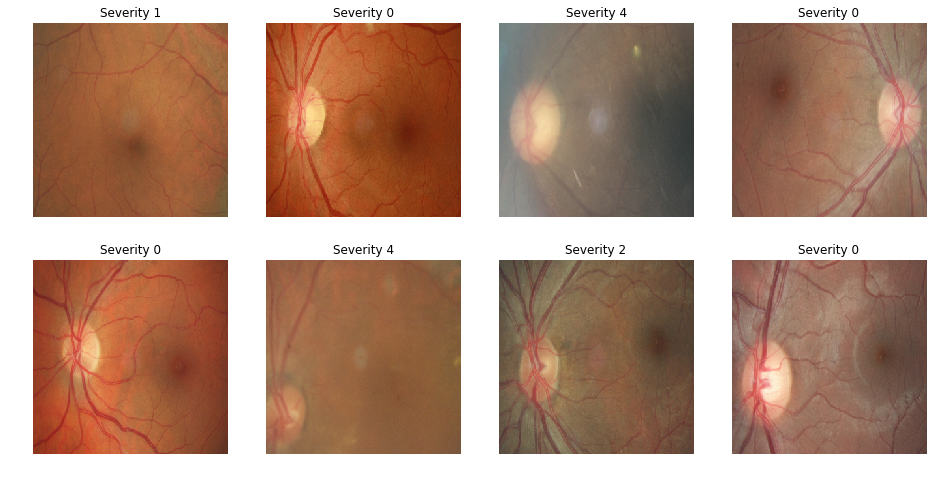

In [10]:
t_x, t_y = next(valid_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

In [ ]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

## Attention model

In [12]:
# from keras.applications.vgg16 import VGG16 as PTModel
# from keras.applications.inception_resnet_v2 import InceptionResNetV2 as PTModel
# from keras.applications.inception_v3 import InceptionV3 as PTModel
from tensorflow.keras.applications.xception import Xception as PTModel



In [ ]:
in_lay = Input(t_x.shape[1:])
base_pretrained_model = PTModel(input_shape = t_x.shape[1:], 
                                weights = 'imagenet',
                                include_top = False )
# base_model_1 = Model(inputs=base_model.get_input_at(0), outputs=base_model.layers[-10].get_output_at(0))
base_pretrained_model.trainable = False
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
# print(len(base_pretrained_model.layers()))
pt_features = base_pretrained_model(in_lay)
bn_features = BatchNormalization()(pt_features)

In [12]:
# from keras.applications.vgg16 import VGG16 as PTModel
# from keras.applications.inception_resnet_v2 import InceptionResNetV2 as PTModel
from keras.applications.inception_v3 import InceptionV3 as PTModel
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input(t_x.shape[1:])
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

87916544/87910968 [==============================] - 23s 0us/step


In [13]:

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, 
                    kernel_size = (1,1), 
                    padding = 'valid', 
                    activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(t_y.shape[-1], activation = 'softmax')(dr_steps)
retina_model = Model(inputs = [in_lay], outputs = [out_layer])
from keras.metrics import top_k_categorical_accuracy
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

retina_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])
retina_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 8, 8, 2048)   8192        inception_v3[1][0]               
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 8, 8, 2048)   0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_95 

In [14]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('retina')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=6) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [17]:
retina_model.fit_generator(train_gen, 
                           steps_per_epoch = train_df.shape[0]//batch_size,
                           validation_data = valid_gen, 
                           validation_steps = valid_df.shape[0]//batch_size,
                              epochs = 50, 
#                               callbacks = callbacks_list,
                             workers = 0, # tf-generators are not thread-safe
                             use_multiprocessing=False, 
                             max_queue_size = 0
                            )

Epoch 1/50
93/93 [==============================] - 610s 7s/step - loss: 1.3183 - categorical_accuracy: 0.4275 - top_2_accuracy: 0.6754 - val_loss: 1.4150 - val_categorical_accuracy: 0.2903 - val_top_2_accuracy: 0.6634
Epoch 2/50
93/93 [==============================] - 600s 6s/step - loss: 1.3067 - categorical_accuracy: 0.4252 - top_2_accuracy: 0.6815 - val_loss: 1.4529 - val_categorical_accuracy: 0.2902 - val_top_2_accuracy: 0.6483
Epoch 3/50
93/93 [==============================] - 584s 6s/step - loss: 1.3001 - categorical_accuracy: 0.4294 - top_2_accuracy: 0.6865 - val_loss: 1.4117 - val_categorical_accuracy: 0.2567 - val_top_2_accuracy: 0.6736
Epoch 4/50
93/93 [==============================] - 584s 6s/step - loss: 1.2920 - categorical_accuracy: 0.4386 - top_2_accuracy: 0.6854 - val_loss: 1.5203 - val_categorical_accuracy: 0.1946 - val_top_2_accuracy: 0.6014
Epoch 5/50
93/93 [==============================] - 584s 6s/step - loss: 1.2715 - categorical_accuracy: 0.4467 - top_2_accur